In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

!pip install tqdm
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
def getdata(path):

  # <START>
  df = pd.read_csv(path)
  return df
  # <END>

# Insert the path to the file in the space below
# <START>
path  = '/content/drive/MyDrive/Dataset/reviews.csv'
# <END>

df = getdata(path)
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# <START>
x_train, x_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42, shuffle=True)
# <END>

print(x_train.shape)
print(x_test.shape)

(40000,)
(10000,)


In [5]:
count_positive = 0
count_negative = 0

for i in y_train:
  if i == "positive":
    count_positive += 1
  elif i =="negative":
    count_negative += 1

print("Positive reviews:", count_positive/(count_positive + count_negative)*100, "%")
print("Negative reviews:", count_negative/(count_positive + count_negative)*100, "%")

Positive reviews: 49.902499999999996 %
Negative reviews: 50.0975 %


In [6]:
#The list of stopwords has been coverted into a set, making it faster to check if a given word is in it
stop_words = set(stopwords.words('english'))

# Using the below tokenizer helps us get rid of punctuation,
tokenizer = RegexpTokenizer(r'\w+')
# And the lemmatizer to convert words to simpler forms
lemmatizer = WordNetLemmatizer()

def preprocess(x_set):
    result = []
    for i in x_set:
      # <START>
        i = i.lower()

        # Tokenize and remove punctuation
        tokens = tokenizer.tokenize(i)

        # Lemmatize
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Remove stop words
        out = [token for token in lemmatized_tokens if token not in stop_words]

      # <END>
        result.append(out)
    return result

#Testing the function
test_preprocess = preprocess(["This is an assignment.",'The notebook runs on the cloud.','The cloud, however, is very much on the ground,'])
print(test_preprocess)
assert test_preprocess == [['assignment'], ['notebook', 'run', 'cloud'], ['cloud', 'however', 'much', 'ground']]
x_train_preprocessed = preprocess(x_train)
x_test_preprocessed = preprocess(x_test)

[['assignment'], ['notebook', 'run', 'cloud'], ['cloud', 'however', 'much', 'ground']]


In [7]:
def create_vocabulary(x_train_preprocessed):
  '''Creates a dictionary with all unique words in corpus with id'''
  vocabulary = {}
  id = 1
  # <START>
  for s in x_train_preprocessed:
    #print(s)

    for j in s:
      if(j not in vocabulary.keys()):
        vocabulary[j]=id
        id+=1

  for s in x_test_preprocessed:
    for j in s:
      if(j not in vocabulary.keys()):
        vocabulary[j]=id
        id+=1

  # <END>
  return vocabulary

vocabulary = create_vocabulary(x_train_preprocessed)
print(len(vocabulary))


92224


In [8]:
def convert_to_numerical(x_set):
  converted = []
    # <START>
  for x in x_set:
    numerical_review = [vocabulary[word] for word in x]
    converted.append(numerical_review)
    # <END>
  return converted

#Testing your function
vocab_list = list(vocabulary.keys())
print(convert_to_numerical([[vocab_list[47],vocab_list[186],vocab_list[4005]]]))
assert convert_to_numerical([[vocab_list[47],vocab_list[186],vocab_list[4005]]]) == [[48, 187, 4006]]

[[48, 187, 4006]]


In [9]:
x_train_numerical = convert_to_numerical(x_train_preprocessed)
x_test_numerical = convert_to_numerical(x_test_preprocessed)

print(len(x_train_numerical))

40000


In [10]:
def convert_labels(y_set):
  converted=[]
    # <START>
  for i in y_set:
    if i=='positive':
      converted.append(1)
    else:
      converted.append(0)
    # <END>
  return converted

assert convert_labels(['positive','negative','positive','positive','negative']) == [1,0,1,1,0]

y_train_numerical = convert_labels(y_train)
y_test_numerical = convert_labels(y_test)

print(len(y_train_numerical))

40000


In [11]:
lengths = [len(i) for i in x_train_preprocessed]
lengths_sum = sum(lengths)
num_lengths = len(lengths)
avg_length = lengths_sum/num_lengths
max_length = max(lengths)

print("Average length of reviews: ", avg_length)
print("Length of the longest review: ", max_length)

Average length of reviews:  126.3005
Length of the longest review:  1470


In [12]:
def normalize(x_set, max_length):
    temp = np.zeros((len(x_set), max_length),dtype=int)
    for i, sentence in enumerate(x_set):
        if len(sentence) != 0:
            temp[i, -len(sentence):] = np.array(sentence)[:max_length]
    return temp

max_length = 150

x_train_normalized = normalize(x_train_numerical, max_length)
x_test_normalized = normalize(x_test_numerical, max_length)

In [13]:
final_train_data = TensorDataset(torch.from_numpy(x_train_normalized), torch.tensor(y_train_numerical))
final_test_data = TensorDataset(torch.from_numpy(x_test_normalized), torch.tensor(y_test_numerical))

In [14]:
batch_size = 64

train_batch_loader = DataLoader(final_train_data, shuffle=True, batch_size=batch_size)
test_batch_loader = DataLoader(final_test_data, shuffle=True, batch_size=batch_size)

In [15]:
sample_batch = train_batch_loader
for x, y in sample_batch:
  print("Input size:", x.size())
  print("Input feature: \n", x)
  print("Label: \n", y)
  break


Input size: torch.Size([64, 150])
Input feature: 
 tensor([[    0,     0,     0,  ...,   584,   126,  3933],
        [    0,     0,     0,  ..., 22234,   979,  4528],
        [    0,     0,     0,  ..., 11850,   691,    76],
        ...,
        [    0,     0,     0,  ..., 24941,  1795, 13927],
        [    0,     0,     0,  ...,  2347,  2093, 26538],
        [    0,     0,     0,  ...,   849,  1333,    48]])
Label: 
 tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0])


In [16]:
class RNN_SA(nn.Module):

    # CLASS CONSTRUCTOR
    def __init__(self, num_layers, hidden_layer_size, embedding_layer_size, output_layer_size, vocabulary_size, dropout_probability=0.5):
        super(RNN_SA,self).__init__()

        # Initialize the class variables with the values provided as arguments
        self.output_layer_size = output_layer_size
        self.hidden_dim = hidden_layer_size
        self.num_layers = num_layers
        self.vocabulary_size = vocabulary_size

        # <START>
        # Define the embedding layer
        self.embedding = nn.Embedding(vocabulary_size,embedding_layer_size)

        # Define the LSTM unit
        self.lstm = nn.LSTM(embedding_layer_size, hidden_layer_size, num_layers, batch_first=True)

        # Define the Dropout layer
        self.dropout_layer =nn.Dropout(p=0.3, inplace=False)

        # Define the linear hidden layer and output sigmoid layer
        self.linear_layer = nn.Linear(in_features=256, out_features=1, bias=True)
        self.sigmoid_layer = nn.Sigmoid()
        # <END>

    def forward(self, x):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out,_ = self.lstm(embeds)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout_layer(lstm_out)
        out = self.linear_layer(out)
        sig_out = self.sigmoid_layer(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out

In [17]:
num_layers = 2
vocabulary_size = len(vocabulary) + 1
embedding_layer_size = 64
output_layer_size = 1
hidden_layer_size = 256


model = RNN_SA(num_layers, hidden_layer_size, embedding_layer_size, output_layer_size, vocabulary_size, dropout_probability=0.3)

print(model)

RNN_SA(
  (embedding): Embedding(92225, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (linear_layer): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid_layer): Sigmoid()
)


In [18]:
MY_NOTEBOOK_DIED_MID_TRAINING = False

if MY_NOTEBOOK_DIED_MID_TRAINING:
  model = torch.load('/content/drive/MyDrive/state_dict.pt')

In [19]:
learning_rate = 1e-3
num_epochs = 3

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

def accuracy(prediction, label):
    prediction = torch.round(prediction.squeeze())
    return torch.sum(prediction == label.squeeze()).item()

min_loss_attained = np.Inf    # this variable will contain the minimum value of the loss function attained in any of the epochs.
                              #It is used to discard the results of further epochs if their losses are more than min_loss_attained.

epoch_train_loss,epoch_test_loss = [],[]
epoch_train_acc,epoch_test_acc = [],[]    # These lists will hold the average loss and accuracy values of each epoch



for epoch in range(num_epochs):
  train_losses = 0.0
  train_accuracy = 0.0

  progress_bar = tqdm(total=len(train_batch_loader), desc='Training', leave = True)  # You don't need to worry about this line,
                                                                                          # it's just to display a progress bar that shows the percentage trained

  model.train()

  for inputs, labels in train_batch_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # <START>
    # Don't forget to reset the gradients before beginning!
    output = model(inputs)

    # compute the loss and implement the back propagation step
    loss = criterion(output,labels.float())
    loss.backward()


    # <END>

    # Calculating loss and accuracy; we will store the cumulative values and finally use them to compute the average loss and accuracy of the epoch
    train_losses += loss.item()
    acc = accuracy(output,labels)
    train_accuracy += acc

    nn.utils.clip_grad_norm_(model.parameters(), 5) # This line helps avoid the exploding gradient problem

    optimizer.step()

    progress_bar.update(1)

  progress_bar.close()

  # After the training run of each epoch, we will evaluate the performance of our model

  test_losses = 0.0  # Again, this will store cumulative loss
  test_accuracy = 0.0   # and this will store cumulative test accuracy

  model.eval()

  for inputs, labels in test_batch_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # <START>   # Compute the loss
    output = model(inputs)
    test_loss = criterion(output,labels.float())
    # <END>

    test_losses += test_loss.item()

    acc = accuracy(output,labels)
    test_accuracy += acc


  epoch_train_accuracy = train_accuracy/len(train_batch_loader.dataset)
  epoch_test_accuracy = test_accuracy/len(test_batch_loader.dataset)


  avg_train_loss = np.mean(train_losses)
  avg_test_loss = np.mean(test_losses)

  epoch_train_loss.append(avg_train_loss)
  epoch_test_loss.append(avg_test_loss)
  epoch_test_acc.append(epoch_test_accuracy)
  epoch_train_acc.append(epoch_train_accuracy)

  print(f'Epoch {epoch+1}')
  print(f'train_loss : {avg_train_loss} test_loss : {avg_test_loss}')
  print(f'train_accuracy : {epoch_train_accuracy*100} test_accuracy : {epoch_test_accuracy*100}')
  if avg_test_loss < min_loss_attained:
    torch.save(model.state_dict(), '/content/drive/MyDrive/state_dict.pt')
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_loss_attained, avg_test_loss))
    min_loss_attained = avg_test_loss
  print(70*'=')

Training: 100%|██████████| 625/625 [25:58<00:00,  2.49s/it]


Epoch 1
train_loss : 439.4326992034912 test_loss : 109.67152661085129
train_accuracy : 51.735 test_accuracy : 50.74999999999999
Validation loss decreased (inf --> 109.671527).  Saving model ...


Training: 100%|██████████| 625/625 [26:54<00:00,  2.58s/it]


Epoch 2
train_loss : 433.1603587269783 test_loss : 108.1860146522522
train_accuracy : 51.654999999999994 test_accuracy : 52.26
Validation loss decreased (109.671527 --> 108.186015).  Saving model ...


Training: 100%|██████████| 625/625 [16:45<00:00,  1.61s/it]


Epoch 3
train_loss : 431.8604129552841 test_loss : 107.93724882602692
train_accuracy : 51.790000000000006 test_accuracy : 52.290000000000006
Validation loss decreased (108.186015 --> 107.937249).  Saving model ...


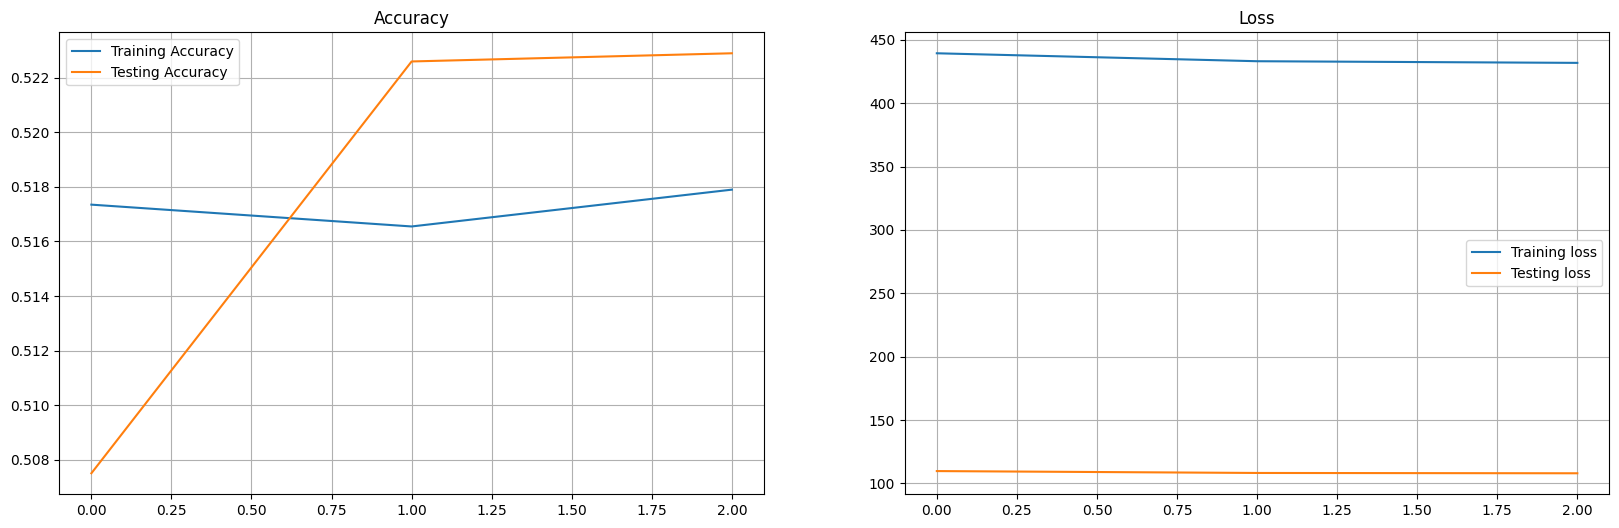

In [20]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_train_acc, label='Training Accuracy')
plt.plot(epoch_test_acc, label='Testing Accuracy')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_loss, label='Training loss')
plt.plot(epoch_test_loss, label='Testing loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()